### Análise de Dados - Tecnologia Embarcada (.shp)

#### Análise de Operação de Aplicação de Herbicida

Dados:

Na análise abaixo foram utilizados dados disponibilizados no John Deere's Github, exemplificando dados obtidos com tecnologia embarcada, em uma aplicação de herbicida. Os dados estão no formato Shapefile (.shp), saida padrão de arquivos da plataforma Operation Center - John Deere.
    
Objetivo:

A análise tem como objetivo principal avaliar a qualidade da aplicação, quantificada pelo desvio entre a taxa aplicada ('AppliedRat') e a taxa alvo ('TargetRat'). Como objetivos específicos destaco a identificação das regiões com subdose e superdose, assim como a determinação do percentual de área trabalhada dentro de uma faixa de tolerância.
    
[1]. John Deere's Github: https://github.com/JohnDeere

#### Importando Bibliotecas e Pacores .py

In [1]:
import pandas as pd
import shapefile
import matplotlib.pyplot as plt
from datetime import datetime
#import numpy as np
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.colors import RGB

#Plot Matplotlib no Jupyter Notebook
%matplotlib inline
#Plot Bokeh no Jupyter Notebook
output_notebook()

Loading BokehJS ...

#### Declarando Funções e Métodos

In [2]:
def error_class(error:float):
    """
    Método para classificação de erro entre intervalos de erro pré-estabelecidas
    """
    if error < -0.1:
        class_heat = "[,-10%)"
    elif error >= -0.1 and error < -0.05:
        class_heat = "[-10%,-5%["
    elif error >= -0.05 and error <= 0.05:
        class_heat = "[-5%,5%]"
    elif error > 0.05 and error <= 0.10:
        class_heat = "]5%,10%]"
    elif error > 0.1:
        class_heat = "(10%,]"
    else:
        class_heat = "NA"
    
    return class_heat

#### Conhecendo os dados

##### Metadados

In [3]:
json_app = pd.read_json("data\sample_data_MyJohnDeere_Application\doc\Merriweather Farms-JT-01-Sonic Tilled Use 1-Deere-Metadata.json", orient = 'index')

json_app

,0
Version,1.0
OrgId,223031
ClientId,46234f43-0000-1000-4014-e1e1e11124e0
ClientName,Merriweather Farms
FarmId,4641d448-0000-1000-4033-e1e1e11124e0
FarmName,JT
FieldId,e61b83f4-3a12-431e-8010-596f2466dc27
FieldName,01
Operation,Application
CropSeason,2016


In [4]:
json_app[0]['DataAttributes']

[{'Name': 'Time', 'Description': 'Timestamp'},
 {'Name': 'Heading', 'Description': 'Machine Heading'},
 {'Name': 'DISTANCE',
  'Unit': 'ft',
  'Description': 'Distance Travelled From Previous Point'},
 {'Name': 'SWATHWIDTH', 'Unit': 'ft', 'Description': 'Width Of Element'},
 {'Name': 'Product', 'Description': 'Product Name'},
 {'Name': 'SECTIONID', 'Description': 'Element Id'},
 {'Name': 'AppliedRate', 'Unit': 'gal1ac-1', 'Description': 'Applied Rate'},
 {'Name': 'ControlRate', 'Unit': 'gal1ac-1', 'Description': 'Control Rate'},
 {'Name': 'TargetRate', 'Unit': 'gal1ac-1', 'Description': 'Target Rate'},
 {'Name': 'Elevation', 'Unit': 'ft', 'Description': 'Elevation'},
 {'Name': 'IsoTime', 'Description': 'Precise Timestamp'}]

In [5]:
json_app[0]['Product']

{'ProductName': 'Tank Mix',
 'BrandName': '',
 'TankMix': True,
 'Rate': {'Value': 12.5, 'Unit': 'gal1ac-1'},
 'Components': [{'Carrier': False,
   'Name': 'Sonic',
   'Rate': {'Value': 5.63, 'Unit': 'ozm1ac-1'}},
  {'Carrier': True,
   'Name': 'Water',
   'Rate': {'Value': 12.5, 'Unit': 'gal1ac-1'}}]}

In [6]:
farm = json_app[0]['FarmName']
field_name = str(json_app[0]['FieldName'])
crop_season = str(json_app[0]['CropSeason'])
product = json_app[0]['Product']['ProductName']

#### Lendo os dados

In [7]:
#Lendo arquivo .shp
sf = shapefile.Reader("data\sample_data_MyJohnDeere_Application\doc\Merriweather Farms-JT-01-Sonic Tilled Use 1.shp")

shapes = sf.shapes()
head = [x[0] for x in sf.fields][1:]  #buscando cabeçalhos
records = [y[:] for y in sf.records()]  #buscando atributos
lat = [s.points[0][0] for s in sf.shapes()]  #buscando Latitude
long = [s.points[0][1] for s in sf.shapes()] #buscando Longtude

#Criando Dataframe para transformação dos dados
sf_df = pd.DataFrame(data = records, columns= head)

In [8]:
#Visão inicial dos dados
sf_df.head(3)

,Time,Heading,DISTANCE,SWATHWIDTH,Product,SECTIONID,AppliedRat,ControlRat,TargetRate,Elevation,IsoTime
0,4/24/2016 11:51:06 AM,4.679687,1.599586,11.25,Sonic Tilled Use 1,180,20.675935,None,13.299186,782.531578,2016-04-24T11:51:06.200Z
1,4/24/2016 11:51:06 AM,4.679687,1.599586,8.75,Sonic Tilled Use 1,181,20.675935,None,13.299186,782.531578,2016-04-24T11:51:06.200Z
2,4/24/2016 11:51:06 AM,4.679687,1.599586,13.75,Sonic Tilled Use 1,182,20.675935,None,13.299186,782.531578,2016-04-24T11:51:06.200Z


In [9]:
#Adicionando as informações Lat-Long ao Dataframe
sf_df['Lat'] = lat
sf_df['Long'] = long

#Convertendo o 'Time' de str para datetime
sf_df['Time'] = sf_df['IsoTime'].apply(lambda x: datetime.fromisoformat(x[:23]))

#Convertendo medidas do Sistema Americano para Sistema Internacional de Medidas
sf_df['DISTANCE'] = sf_df['DISTANCE']*0.3048 #m
sf_df['SWATHWIDTH'] = sf_df['SWATHWIDTH']*0.3048 #m
sf_df['Size'] = sf_df['DISTANCE']*sf_df['SWATHWIDTH']/10000 #ha
sf_df['AppliedRat'] = sf_df['AppliedRat']*3.78541/0.404686 #l/ha
sf_df['TargetRate'] = sf_df['TargetRate']*3.78541/0.404686 #l/ha
sf_df['Elevation'] = sf_df['Elevation']*0.3048 #m

#Calculando o Desvio da Aplicação em relação ao alvo, e classificando erro por intervalos pré-definidos
sf_df['Error'] = (sf_df['AppliedRat']-sf_df['TargetRate'])/sf_df['TargetRate']
sf_df['Error_Class'] = sf_df['Error'].apply(lambda x: error_class(x))

In [10]:
#Estatísticas descritivas
sf_df.describe()

,Heading,DISTANCE,SWATHWIDTH,SECTIONID,AppliedRat,TargetRate,Elevation,Lat,Long,Size,Error
count,28650.000000,28650.000000,28650.000000,28650.000000,28650.000000,2.865000e+04,28650.000000,28650.000000,28650.000000,28650.000000,28650.000000
mean,199.574700,1.085945,3.431208,184.223630,126.011956,1.243998e+02,238.116347,-93.152282,41.667807,0.000373,0.012959
std,96.195526,0.127876,0.498208,2.517392,16.604721,5.161473e-11,0.381311,0.001178,0.000885,0.000070,0.133479
min,0.015625,0.237554,2.667000,180.000000,8.453016,1.243998e+02,236.673625,-93.154795,41.666148,0.000081,-0.932050
25%,90.624344,1.057554,3.429000,182.000000,122.589840,1.243998e+02,237.935625,-93.153205,41.667062,0.000317,-0.014550
50%,191.044969,1.117554,3.429000,184.000000,124.869810,1.243998e+02,238.217625,-93.152278,41.667875,0.000380,0.003778
75%,270.494344,1.167554,3.429000,186.000000,127.557788,1.243998e+02,238.358625,-93.151274,41.668555,0.000404,0.025386
max,359.988407,1.217554,4.191000,188.000000,651.438780,1.243998e+02,238.724625,-93.150249,41.669477,0.000510,4.236653


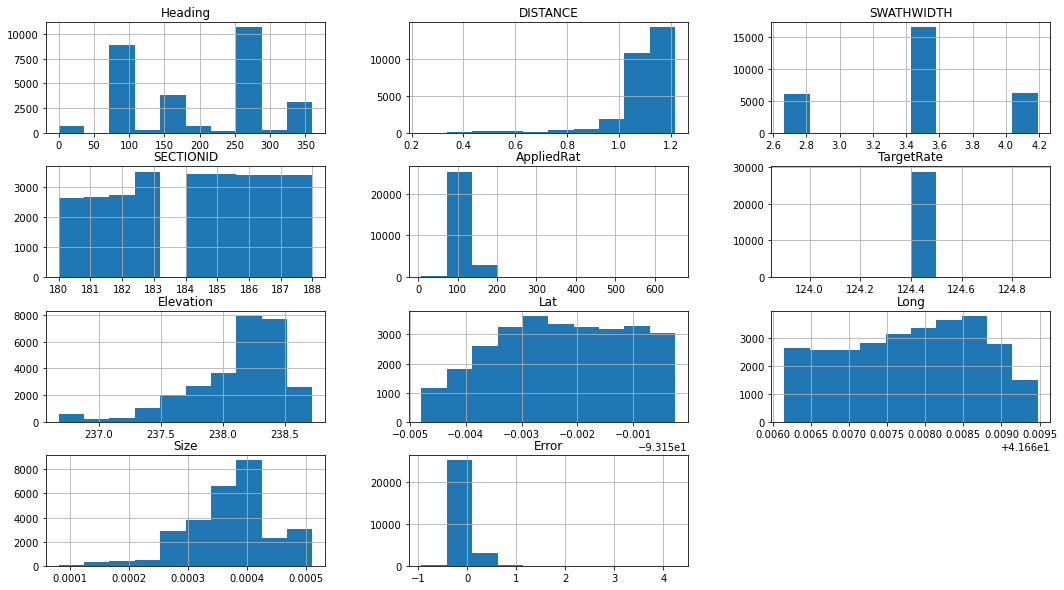

In [11]:
#Histograma - Overview
sf_df.hist(figsize=(18,10))
plt.show()

Obs.:

> Note que quase não há variações na taxa alvo ('Target Rate') .:. Aplicação em Taxa Fixa

> Houve variações de seção de trabalho ('SWATHWIDTH') ao longo da atividade

> Houveram alguns pontos com altas taxas de aplicação ('AppliedRat'), mesmo não sendo representativos*, estão descolando o histograma de AppliedRat e Error. Para melhor visualização vamos agrupar as extremidades, para avaliarmos a distribuição dos dados

*note que 75% dos dados estão próximos à média


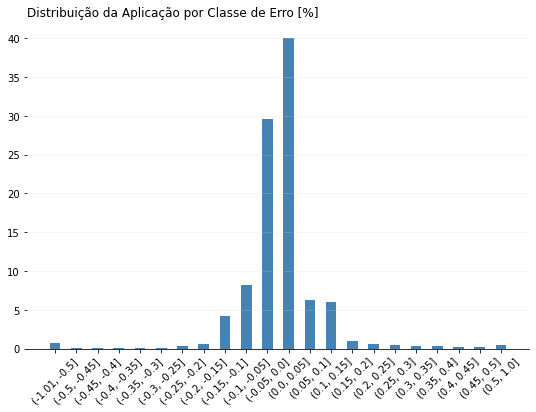

In [12]:
#Segmentado e Classificando os valores de Erro
labels = [-1.01] #Limite inferior ##.01 para conter os pontos com aplicação 0 (-100%)
           
for i in range(-50, 51, 5):
    labels.append(i/100) #classes centrais variando em 5%
        
labels.append(1) #Limite superior (+100%)

sf_df['Ranges'] = pd.cut(sf_df["Error"], labels).apply(lambda x:str(x))
sf_df_out_hist = sf_df.groupby(['Ranges'], as_index = False)['Size'].sum()
sf_df_out_hist['%Hist'] = sf_df_out_hist['Size']/sf_df_out_hist['Size'].sum()*100

#Plot de Soma de Área por Classe de Erro
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot()

ax.bar(sf_df_out_hist['Ranges'],sf_df_out_hist['%Hist'], color=(0.275, 0.51, 0.706), width=0.5)
ax.set_title('Distribuição da Aplicação por Classe de Erro [%]', loc='left', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.grid(axis='y',color='lightgrey', linestyle='-', linewidth=1, alpha=0.2)
ax.tick_params(axis='x',labelsize=10,labelrotation=45)
ax.tick_params(axis='y',labelsize=10)

In [13]:
#Considerando [-5%, 5%] como faixa de tolerância
##Apenas exemplo, a tolerância pode variar com: regras de negócio, produto aplicado, cultura, tecnologia embregada, etc..
size_conf = sf_df['Size'][sf_df['Ranges'] == '(-0.05, 0.0]'].sum()+sf_df['Size'][sf_df['Ranges'] == '(0.0, 0.05]'].sum()
conf = size_conf/sf_df['Size'].sum()*100

print('Área Conforme [ha]: '+'{0:4.2f}'.format(size_conf), '\nPercentual de Conformidade [%]: '+'{0:4.2f}'.format(conf))

Área Conforme [ha]: 7.43 
Percentual de Conformidade [%]: 69.59


In [14]:
#Devemos ainda, avaliar o impacto do outlier dos valores com erro +100%
print('Área Total [ha]: '+'{0:4.2f}'.format(sf_df['Size'].sum()),
      '\nÁrea com Outlier [ha]: '+'{0:4.2f}'.format(sf_df_out_hist["Size"].sum()),
      '\nVariação [%]: '+'{0:4.2f}'.format(100*(sf_df_out_hist["Size"].sum()-sf_df["Size"].sum())/sf_df["Size"].sum())
     )

Área Total [ha]: 10.67 
Área com Outlier [ha]: 10.66 
Variação [%]: -0.10


Obs.:

> O percentual de conformidade é um importante KPI para o processo, e sua meta deve ser definido como regra de negócio assim como a faixa de tolerância

> O outlier de erros +100% melhorou a vizualização as principais classes de erros, e representou apenas -0.10% da área trabalhada

> Além de identificar as principais classes de erro, é interessante identificarmos onde na aplicação estes ocorreram


In [15]:
#Calculando Taxa Média e Desvio Médio ponderado pela área
sf_df['wTargetRate'] = sf_df['TargetRate'] * sf_df['Size']
sf_df['wAppliedRat'] = sf_df['AppliedRat'] * sf_df['Size']

target_WAvg = sf_df['wTargetRate'].sum()/sf_df['Size'].sum()
applied_WAvg = sf_df['wAppliedRat'].sum()/sf_df['Size'].sum()
error_WAvg = 100 * (applied_WAvg-target_WAvg)/target_WAvg
size_sum = sf_df['Size'].sum()

#Informações Gerais
str_legend = ['{0:4.2f}%'.format(error_WAvg),
              '{0:4.2f}'.format(target_WAvg),
              '{0:4.2f}'.format(applied_WAvg),
              '{0:4.2f}'.format(size_sum)]

In [16]:
#Print das Informações Gerais
title_info = "Inf. Gerais:\n\nErro Médio: "+str_legend[0]+"\nTaxa Alvo [l/ha]: "+str_legend[1]+"\nTaxa Média [l/ha]: "+str_legend[2]+"\nÁrea Trabalhada [ha]: "+str_legend[3]+"\n"
print(title_info)

#Definindo principais classes de erro para plot
lst_loop = ["[,-10%)","[-10%,-5%[","[-5%,5%]","]5%,10%]","(10%,]"] #classes de erro
tx_alvo = float(str_legend[1]) #taxa alvo
lst_legend = ['<{0:4.0f}'.format(0.9*tx_alvo),
              '[{0:4.0f}'.format(0.9*tx_alvo)+',{0:4.0f}['.format(0.95*tx_alvo),
              '[{0:4.0f}'.format(0.95*tx_alvo)+',{0:4.0f}]'.format(1.05*tx_alvo),
              ']{0:4.0f}'.format(1.05*tx_alvo)+',{0:4.0f}]'.format(1.1*tx_alvo),
              '>{0:4.0f}'.format(1.1*tx_alvo)] #faixas percentuais na dose alvo 

#Paleta de Cores
paleta = [RGB(192, 8, 2), RGB(255, 119, 0), RGB(255, 239, 3), RGB(130, 204, 0), RGB(0, 139, 54)]

#Plot - Mapa de Aplicação (Lat-Long) considerando principais classes de erro
p = figure(title="Mapa de Aplicação - "+ crop_season+" - "+farm+" - "+field_name+" - "+product,
           plot_width=900, plot_height=600,
           tooltips=[("Lat,Long", "($x, $y)")])

#Loop para plot de cada classe
cont_int = 0
    
for i in lst_loop[::-1]:
    sf_df_loc = sf_df[sf_df['Error_Class']==i]
    px = sf_df_loc['Lat']
    py = sf_df_loc['Long']

    p.circle(px, py, size=1,
             line_color=paleta[cont_int],
             fill_color=paleta[cont_int],
             fill_alpha=0.75,
             legend_label=lst_legend[cont_int])
    p.legend.orientation = "horizontal"
    p.legend.location = "top_right"
    cont_int += 1
    
p.xaxis.axis_label = 'Latitude'
p.yaxis.axis_label = 'Longitude'
p.title_location = 'above' 
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
          
show(p)

Inf. Gerais:

Erro Médio: 0.73%
Taxa Alvo [l/ha]: 124.40
Taxa Média [l/ha]: 125.31
Área Trabalhada [ha]: 10.67



Obs.:

> Maiores erros <112l/ha e >137l/ha estão localizados na bordadura, provavelmente por variações bruscas de velocidade em manobras ou obstáculos

> O projeto das linhas de trabalho, otimizando manobras irá melhorar o percentual de conformidade da aplicação

> O erro médio não é um bom parâmetro para a avaliação da qualidade, super-dose compensam sub-dose, definindo faixas de tolerância adequadas, o percentual de confirmidade representa melhor sistemas com controle de taxa